# Homework 7

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 27th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators


**Joe Davison**
<br>
**Anna Davydova**
<br>
**Michael S. Emanuel**
<br>
**Dylan Randle**
<br>

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

## Standard boilerplate to import torch and torch related modules
import torch

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn

## Question 1: Mon pays c'est l'MNIST. Mon cœur est brise de Logistic Regression.

The [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database) is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves.  It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You will be using PyTorch to build a handwritten digit classifier that you will train, validate, and test with MNIST. 

Your classifier MUST implement a multinomial logistic regression model (using softmax). It will take as input an array of pixel values in an image and output the images most likely digit label (i.e. 0-9). You should think of the pixel values as features of the input vector.  

Using the softmax formulation, your PyTorch model should computes the cost function using an L2 regularization approach (see `optim.SGD` in PyTorch or write your own cost function) and minimize the resulting cost function using mini-batch stochastic gradient descent.  We provided  extensive template code in lab.

Construct and train your classifier using a batch size of 256 examples, a learning rate $\eta$=0.1, and a regularization factor $\lambda$=0.01.

1.1. Plot 10 sample images from the MNIST dataset (to develop intuition for the feature space).

1.2. Currently the MNIST dataset in Torchvision allows a Train/Test split.  Use PyTorch dataloader functionality to create a Train/Validate/Test split  of 50K/10K/10K samples.

**Hint:** Lab described a way to do it keeping within the MNIST `DataLoader` workflow: the key is to pass a `SubsetRandomSampler` to `DataLoader`

1.3. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.

1.4. Train your model using SGD to minimize the cost function. Use as many epochs as you need to achive convergence.

1.5. Plot the cross-entropy loss on the training set as a function of iteration.

1.6. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

1.6. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for each of the different values of λ? Give an approximate answer supported by using the plots.

1.7. Select what you consider the best regularization parameter and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?

1.8. What classes are most likely to be misclassified? Plot some misclassified training and test set images.

**Gratuitous Titular Reference**:  The recently departed French rockstar Johnny Hallyday just posthumously released what looks to be his biggest album ever "Mon pays c'est l'amour".  The album sold 300,000 copies on its first day of release.

<div class="answer-separator">
------------------------
</div>

In [2]:
# Additional library utilities
import pickle
import time
from typing import Dict

In [3]:
# Import the classes from mnist that do all the actual work :)
# from mnist import MNIST_Classifier, LogisticRegression, TwoLayerNetwork
"""
Harvard IACS AM 207
Homework 7

Michael S. Emanuel
Mon Oct 22 22:01:33 2018
"""

import numpy as np
import matplotlib.pyplot as plt
## Standard boilerplate to import torch and torch related modules
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler

# *************************************************************************************************
# ATTRIBUTION:
# This code is mostly imported as-is from the PyTorch lab.
# I usually avoid importing large blocks of code for homework assignments,
# but given that there is quite a bit of code and that we were urged
# to do so for this assignment by the teaching staff, I am following this directive.

# *************************************************************************************************
# Regression Parent Class
class Regression(object):
    
    def __init__(self):
        self.params = dict()

    def get_params(self, k):
        return self.params.get(k, None)

    def set_params(self, **kwargs):
        for k,v in kwargs.items():
            self.params[k] = v


    def fit(self, X, y):
        raise NotImplementedError()
        
    def predict(self, X):
        raise NotImplementedError()
        
    def score(self, X, y):
        raise NotImplementedError()


# *************************************************************************************************
## Our PyTorch implementation of Logistic Regression
class LogisticRegression(nn.Module):

    ## the constructor is where we'll define all our layers (input, hidden, and output)
    def __init__(self):

        ## this line creates an instance of our parent (or base) class which in this case
        ## is nn.Module.
        super().__init__()

        ## in the lines below we'll create instance variables and assign them torch.nn Models
        ## in order to create our layers.  You should ordinarily have one variable definition for each layer
        ## in your neural network except for the output layer.  The output layer is defined by the number of
        ## outputs in your last layer. Since we're dealing with simple Artificial Neural Networks, we should
        ## predominantly be using nn.Linear.  
        self.layer_1_linear = nn.Linear(784, 10)

 
    # forwards takes as a parameter x -- the batch of inputs that we want to feed into our neural network model
    # and returns the output of the model ... i.e. the results of the output layer of the model after forward
    # propagation through our model. practically this means you should call each layer you defined in the
    # constructor in sequence plus any activation functions on each layer.
    def forward(self, x):
     
        # call all our layers on our input (in this case we only need one)
        y = self.layer_1_linear(x)

        return y
    

# *************************************************************************************************
class SoftmaxRegression(nn.Module):
    """
    This model explicitly does the softmax activation.
    Should not be used when criterion=nn.CrossEntropyLoss
    """

    def __init__(self):

        super().__init__()
        self.layer_1_linear = nn.Linear(784, 10)
        self.layer_2_softmax = nn.Softmax(dim=0)
 
    def forward(self, x):
     
        # Call layers in order
        z1 = self.layer_1_linear(x)
        y = self.layer_2_softmax(z1)
        return y
    

# *************************************************************************************************
class TwoLayerNetwork(nn.Module):
    """Two layer neural network with one hidden layer"""

    def __init__(self, num_hidden: int):

        super().__init__()
        # The linear layer
        self.layer_1_linear = nn.Linear(784, num_hidden)
        # Use Xavier initialization weights for this layer
        torch.nn.init.xavier_uniform_(self.layer_1_linear.weight)
        # The activation layer
        self.layer_1_activation = nn.Tanh()
        # Fully connected output layer
        self.layer_2_linear= nn.Linear(num_hidden, 10)
 
    def forward(self, x):
     
        # call all our layers on our input
        z1 = self.layer_1_linear(x)
        a1 = self.layer_1_activation(z1) 
        y = self.layer_2_linear(a1)
        return y
    

# *************************************************************************************************
class MNIST_Classifier(Regression):
    
    def __init__(self, model, learning_rate, weight_decay, batch_size, epochs, validation_size):
        
        super().__init__()
                
        ## Add inputs to parameters
        self.set_params(learning_rate=learning_rate,
                        weight_decay=weight_decay,
                        batch_size=batch_size,
                        validation_size=validation_size,
                        epochs=epochs)   

        ## Load MNIST Data
        train_dataset, test_dataset, train_loader, validation_loader, test_loader = self.load_data()
        
        ## Add Datasets and Data Loaders to our params
        self.set_params(train_dataset=train_dataset, 
                        train_loader=train_loader,
                        validation_loader=validation_loader,
                        test_dataset=test_dataset,
                        test_loader=test_loader,
                        is_fit = False)
        
        
        ## Here we define our loss function.  We're using CrossEntropyLoss but other options include
        ## NLLLoss (negative log likelihood loss for when the log_softmax activation is explicitly defined
        ## on the output layer), MSELoss for OLS Regression, KLLDivLoss for KL Divergence, BCELoss
        ## for binary cross entropy and many others
        criterion = nn.CrossEntropyLoss()

        ## Here we define our optimizer.  In class we've been using SGD although in practice one will often
        ## use other optimizers like Adam or RMSProp.  The primary parameter the optimizer takes is the
        ## set of parameters in your model.  Fortunately those are easily accessible via model.paramters()
        ## where model is the instance of the model you defined.  Other useful parameters include lr for the
        ## learning rate and weight_decay for the rate of l2 regularization.
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        
        ## Set the rest of our parameters -- batch_size, learning_rate, epochs, optimizer, model and criterion
        
        ## Add Datasets and Data Loaders to our params
        self.set_params(optimizer=optimizer, 
                        model=model,
                        criterion=criterion)   

    def load_data(self):
        """load MNIST data; split into train / validation / test. Changed from Lab."""
        # Get the batch size and validation size
        batch_size = self.get_params('batch_size')
        validation_size = self.get_params('validation_size')

        # Load training data
        train_dataset = datasets.MNIST(root='./hw3_data',
                                    train=True,
                                    transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)),
                                     ]),
                                    download=True)

        ## Load test data
        test_dataset = datasets.MNIST(root='./hw3_data',
                                   train=False,
                                   transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)),
                                     ]),
                                   download=True)
    
        # Random, non-contiguous split
        num_train: int = len(train_dataset)
        indices = list(range(num_train))
        # Indices for the validation set
        validation_idx = np.random.choice(indices, size=validation_size, replace=False)
        # The training data is the complement of the validation data in the full training set
        train_idx = list(set(indices) - set(validation_idx))
        # Save these indices
        self.set_params(train_idx=train_idx, validation_idx=validation_idx)
        
        # Define samples to be SubsetRandomSampler
        # This section is changed from the lab
        train_sampler = SubsetRandomSampler(train_idx)
        validation_sampler = SubsetRandomSampler(validation_idx)
        # This section is also changed from the lab
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)        
        validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=validation_sampler)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        return (train_dataset, test_dataset, train_loader, validation_loader, test_loader)

    def sample_training_images(self):
        """Create a set of sample images from the MNIST training images"""
        
        training_set = self.get_params('train_dataset')
        sample_indices = np.random.choice(training_set.train_data.size(0), 10)
        
        sample_images = training_set.train_data[sample_indices,:,:].numpy()
        sample_labels = [training_set.train_labels[x] for x in sample_indices]
        
        self.set_params(sample_training_images=sample_images)
        self.set_params(sample_training_labels=sample_labels)
        
    def save_misclassified(self, predictions, images, labels):
        """Create and save a set of sample images misclassified images by the model"""
             
        mislabeled_indices = [index for index,value in enumerate(predictions == labels) if value==False]
        sample_indices = np.random.choice(mislabeled_indices, 10)
        
        sample_images = images[sample_indices,:,:].numpy()
        sample_labels = [predictions[x] for x in sample_indices]
        true_labels = [labels[x] for x in sample_indices]

        self.set_params(misclassified_images=sample_images)
        self.set_params(misclassified_labels=sample_labels)
        self.set_params(misclassified_true_labels=true_labels)
        
        
    def viz_training_images(self):
        """Visualize/Plot sample training images"""
        
        if not self.get_params('training_labels'):
            self.sample_training_images()
        
        # get the images and labels
        sample_images = self.get_params("sample_training_images")
        sample_labels = self.get_params("sample_training_labels")
        
        fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
        plt.suptitle("Some Sample Images from MNIST", fontsize=20, weight='heavy')

        for i in range(5):
            ax1[i].imshow(sample_images[i])
            ax1[i].set_title("MNIST Label: {}".format(sample_labels[i]))
            ax2[i].imshow(sample_images[i+5])
            ax2[i].set_title("MNIST Label: {}".format(sample_labels[i+5]), weight='bold')
            
        plt.show()

    def viz_misclassified_images(self):
        """Visualize/Plot misclassified training images"""

        # get the images and labels
        sample_images = self.get_params("misclassified_images")
        sample_labels = self.get_params("misclassified_labels")
        true_labels = self.get_params("misclassified_true_labels")

        if not sample_labels:
            raise(Exception("Please run predict() or score() with save_misclassified=True"))

        fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
        plt.suptitle("Some Sample Misclassified Images", fontsize=20, weight='heavy')

        for i in range(5):
            ax1[i].imshow(sample_images[i])
            ax1[i].set_title("Label: {} Pred: {}".format(true_labels[i], sample_labels[i]), weight='bold')
            ax2[i].imshow(sample_images[i+5])
            ax2[i].set_title("Label: {} Pred: {}".format(true_labels[i+5], sample_labels[i+5]), weight='bold')

        plt.show()

    ## Stolen from excellent visualization from submission from Madeleine Duran/Sarah Walker
    def viz_training_loss(self, epochs):
        """Visualize/Plot our training loss"""
        
        losses = self.get_params("training_losses")
        
        if type(losses) == type(None):
            raise("Please run fit() to train data")
        
        fig, axes = plt.subplots(nrows=1, ncols=epochs, figsize=(20,5), sharex=True, sharey=True)
        
        for i in range(epochs):
            axes[i].plot(range(len(losses[i])), losses[i])
            axes[i].set_title("epoch {}".format(i+1))
            if i % 2 == 1:
                axes[i].axvspan(-10, 950, facecolor='gray', alpha=0.2)
        plt.subplots_adjust(wspace=0)
        plt.show()       
    
    def viz_validation_loss(self, epoch):
        """Visualize the validation loss"""
        losses = self.get_params('validation_losses')[0:epoch+1]
        weight_decay = self.get_params('weight_decay')
        fig, ax = plt.subplots(figsize=(16,8))
        ax.set_title(f'Validation Accuracy: Epoch {epoch+1} for $\lambda$={weight_decay}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Validation Accuracy')
        if epoch > 0:
            ax.plot(np.arange(epoch+1)+1, losses)
        else:
            ax.axhline(losses[0])
        ax.grid()
        plt.show()
    
    def predict(self, dataset='Test', save_misclassified=True):
        """Classify images based on the fitted logistic regression model"""

        # Get Loader
        if dataset == 'Train':
            loader = self.get_params('train_loader')
            train_idx = self.get_params('train_idx')
            dataset_labels = loader.dataset.train_labels[train_idx]
            dataset_images = loader.dataset.train_data[train_idx]
        elif dataset == 'Validation':
            loader = self.get_params('validation_loader')
            validation_idx = self.get_params('validation_idx')
            dataset_labels = loader.dataset.train_labels[validation_idx]
            dataset_images = loader.dataset.train_data[validation_idx]
        elif dataset == 'Test':
            loader = self.get_params('test_loader')
            dataset_labels = loader.dataset.test_labels
            dataset_images = loader.dataset.test_data
        # Convert to numpy
        dataset_labels = dataset_labels.numpy()
        
        predictions = []
        correct = 0
        model = self.get_params('model')

        for inputs, labels in loader:

            ## get the inputs from the dataloader and turn into a variable for 
            ## feeding to the model
            inputs = Variable(inputs)

            ## Reshape so that batches work properly
            inputs = inputs.view(-1, 28*28)

            # run our model on the inputs
            outputs = model(inputs)

            # get the class of the max log-probability
            pred = outputs.data.max(1)[1]

            correct += (pred == labels).sum()

            # append current batch of predictions to our list
            predictions += list(pred)


        if save_misclassified:
            self.save_misclassified(predictions, dataset_images, dataset_labels)
            
        self.set_params(predictions=predictions, 
                        correct_predictions=correct,
                        prediction_dataset_length=len(dataset_labels),
                        prediction_dataset_labels=dataset_labels
                       )
        return np.array(predictions)
    
    
    def score(self, dataset='Test', save_misclassified=True ):
        """Calculate accuracy score based upon model classification"""

        self.predict(dataset=dataset, save_misclassified=save_misclassified)
        correct = self.get_params('correct_predictions')
        total = self.get_params('prediction_dataset_length')
        accuracy: float = float(correct)/float(total)
        print(f'Dataset: {dataset} \nAccuracy: {correct}/{total} ({100*accuracy:.1f}%)\n')

        return accuracy
        

    def fit(self, viz_val_loss = False):
        """Fit our logistic regression model on MNIST training set"""
        
        ## We defined a number of variables in our constructor -- let's reclaim them here
        optimizer=self.get_params("optimizer")
        model=self.get_params("model")
        epochs=self.get_params("epochs")
        criterion=self.get_params("criterion")
        train_loader=self.get_params("train_loader")
        
        ## Get the Total size of training set
        self.get_params('train_dataset')
        training_size = self.get_params('train_dataset').train_data.size(0)
        
        iterations = int(np.ceil(training_size/self.get_params("batch_size")))
        
        ## We need something to keep track of our losses
        losses = np.zeros((epochs, iterations)) 
        # Also track the losses at the end of every epoch
        losses_val = np.zeros(epochs)
        ## Set Loss Matrix for visualizing
        self.set_params(training_losses=losses)
        self.set_params(validation_losses=losses_val)
                
        ## Our training loop.  We can loop over a fixed number of epochs or
        ## using a sensitivity parameter (i.e. until net change in loss is
        ## below a certain tolerance).  Here we iterate over a fixed number of
        ## epochs
        for epoch in range(epochs):

            ## We defined our train_loader DataLoader earlier.  The train_loader is a
            ## sequence of tuples with the first element of each tuple being
            ## the batched training inputs (the batch_size being defined in your DataLoader)
            ## and the second second element of each tuple being the corresponding labels
            ## more or less all the pytorch classes are built to handle batching transparently

            ## loop through the DataLoader.  Each loop is one iteration.  All the loops
            ## form one epoch
            for batch_index, (inputs, labels) in enumerate(train_loader):

                # Convert the inputs/labels passed from the DataLoader into
                # autograd Variables.  The dataloader provides them as PyTorch Tensors
                # per the transforms.ToTensor() operation.
                inputs, labels = Variable(inputs), Variable(labels)

                ## as mentioned above we receive the inputs as tensors of size (batch_size,1, 28, 28)
                ## which is effectively (batch_size, 28, 28) basically as a 3 dimensional tensor
                ## representing a stack of (28x28) matrices with each matrix element a floating point number
                ## representing the value of that pixel in the image.  Unfortunately our Neural Network model
                ## can't handle that representation and needs a pixel matrices to be flattened into a row vector
                ## of inputs.  The model takes a 2d tensor representing batch of such row vectors each row vector
                ## representing one set of inputs corresponding to one image.  In order to accomplish this
                ## flattening we use the .view method defined on autograd Variables.
                inputs = inputs.view(-1, 28*28)

                # we need to zero out our gradients after each pass
                optimizer.zero_grad()


                ## This is the optimize - forward step - backwards step part of our design pattern

                # this is the forward step --> we calculate the new outputs based upon the input data from
                # this batch and store the outputs in a variable
                outputs = model(inputs)

                # we compare the outputs to the ground truth labels in the batch to calculate the loss for this step
                loss = criterion(outputs, labels)
                
                ## count the loss
                # losses[epoch,batch_index] = loss.data[0]
                losses[epoch,batch_index] = loss.data.item()

                # we run backpropagation on the loss variable which repopulates the gradients all the way
                # back through our model to the input layer
                loss.backward()

                # Use the gradients calculated in the backprop that took place in .backwards() to do a new
                # gradient descent step
                optimizer.step()
                
            # Validation loss at the end of this epoch
            loss_val = self.score(dataset='Validation')
            losses_val[epoch] = loss_val
            
            # Visualize the validation loss each epoch if desired
            if viz_val_loss:
                self.viz_validation_loss(epoch)
            
        # Visualize validation loss by epoch at the very end if not already done
        if not viz_val_loss:
            self.viz_validation_loss(epochs-1)

        # Set flag indicating that the model is now fit
        self.set_params(is_fit=True)
        
        return self

    def is_fit(self):
        return self.get_params('is_fit')
    

In [4]:
# Utilities for persisting variables
# from am207_utils import load_vartbl, save_vartbl
# *************************************************************************************************
def load_vartbl(fname: str) -> Dict:
    """Load a dictionary of variables from a pickled file"""
    try:
        with open(fname, 'rb') as fh:
            vartbl = pickle.load(fh)
    except:
        vartbl = dict()
    return vartbl


def save_vartbl(vartbl: Dict, fname: str) -> None:
    """Save a dictionary of variables to the given file with pickle"""
    with open(fname, 'wb') as fh:
        pickle.dump(vartbl, fh)


In [5]:
# Load persisted table of variables
fname: str = 'mnist.pickle'
vartbl: Dict = load_vartbl(fname)
# Set plot style
matplotlib.rcParams.update({'font.size': 20})

In [6]:
# Train the logistic regression (i.e. softmax) model with the designated inputs
# Set key model parameters
learning_rate = 0.1
weight_decay = 0.01
batch_size = 256
validation_size = 10000
epochs=10
refit = False

## Only run this block if the classifier not already in memory or the refit flag is set
try:    
    mnc = vartbl['mnc']
except:
    # Create a new instance of a logistic regression model
    model = LogisticRegression()
    # Instantiate the MNIST Classifier- mnc for typability
    mnc = MNIST_Classifier(model=model,
                           learning_rate=learning_rate, 
                           weight_decay=weight_decay, 
                           batch_size=batch_size, 
                           validation_size=validation_size, 
                           epochs=epochs)

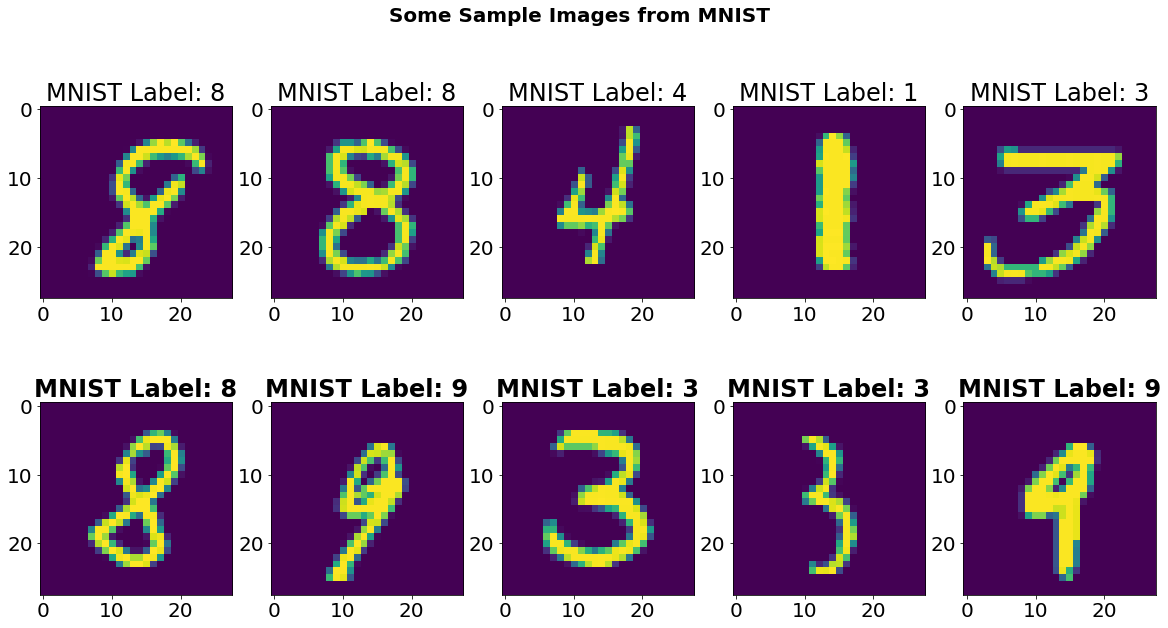

In [7]:
# 1.1. Plot 10 sample images from the MNIST dataset (to develop intuition for the feature space).

## Plot sample images
mnc.viz_training_images()

In [8]:
# 1.2. Currently the MNIST dataset in Torchvision allows a Train/Test split. 
# Use PyTorch dataloader functionality to create a Train/Validate/Test split of 50K/10K/10K samples.

# Hint: Lab described a way to do it keeping within the MNIST DataLoader workflow: 
# the key is to pass a SubsetRandomSampler to DataLoader

# See REVISED version of method load_data() in class MNIST_Classifier

In [9]:
# 1.3. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.

# No changes required to code in the lab; created explicit SoftmaxRegression for fun
# See class LogisticRegression

Dataset: Validation 
Accuracy: 9049/10000 (90.5%)



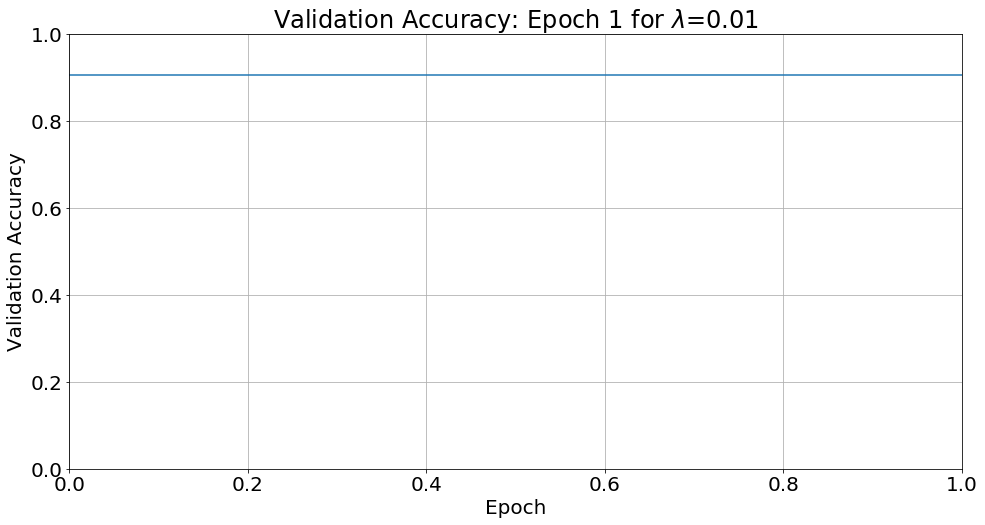

Dataset: Validation 
Accuracy: 9014/10000 (90.1%)



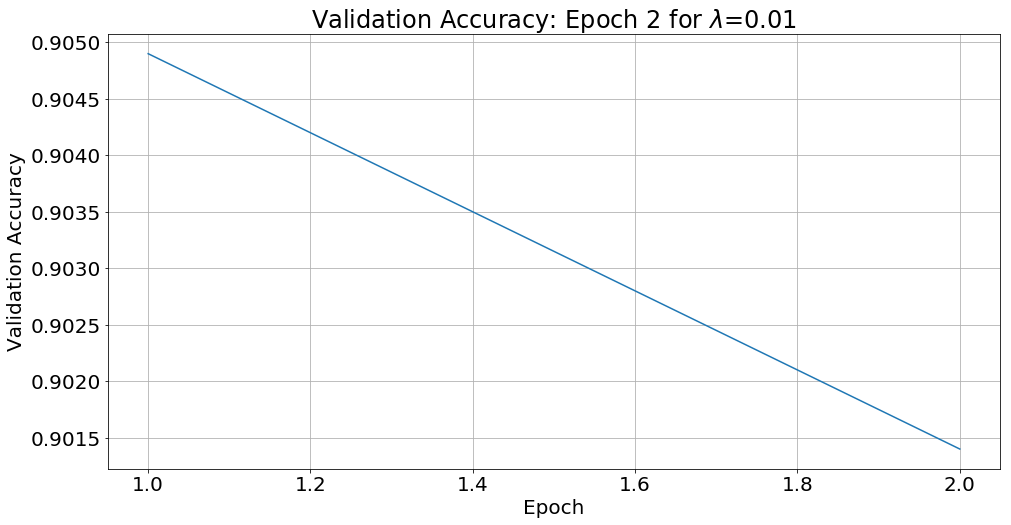

Dataset: Validation 
Accuracy: 9045/10000 (90.5%)



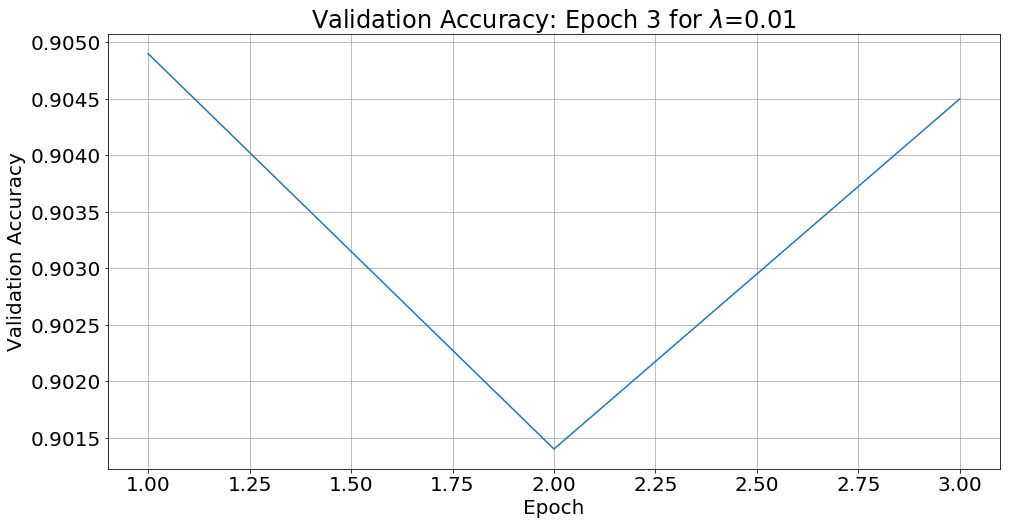

Dataset: Validation 
Accuracy: 9082/10000 (90.8%)



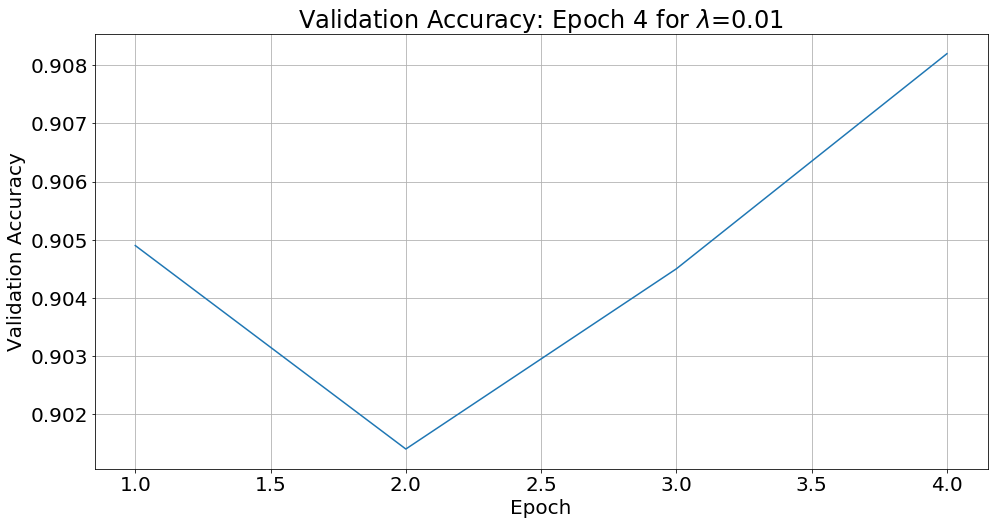

Dataset: Validation 
Accuracy: 9137/10000 (91.4%)



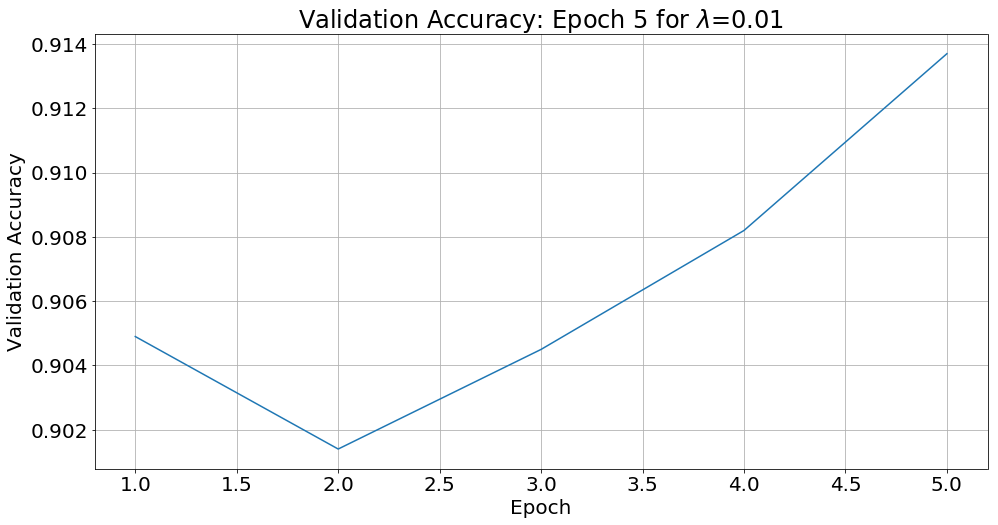

Dataset: Validation 
Accuracy: 9155/10000 (91.5%)



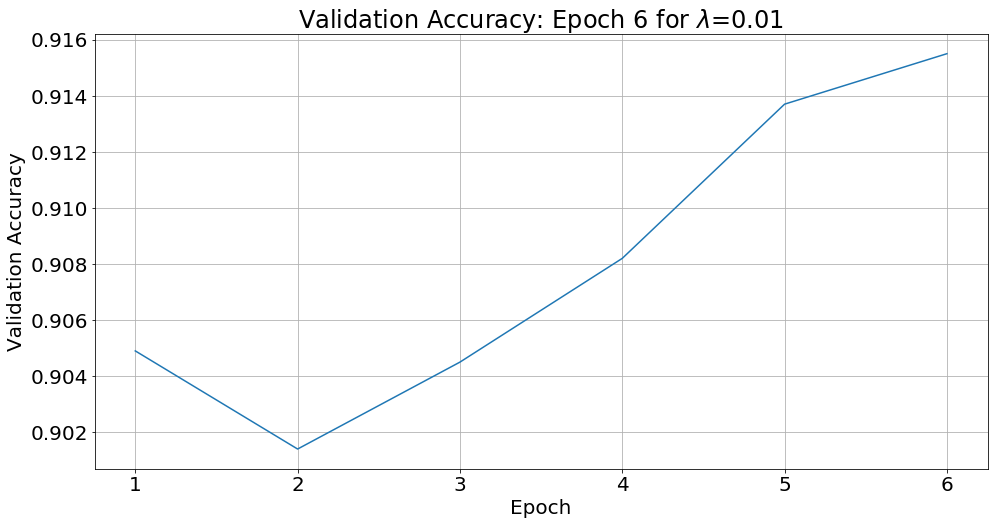

Dataset: Validation 
Accuracy: 9141/10000 (91.4%)



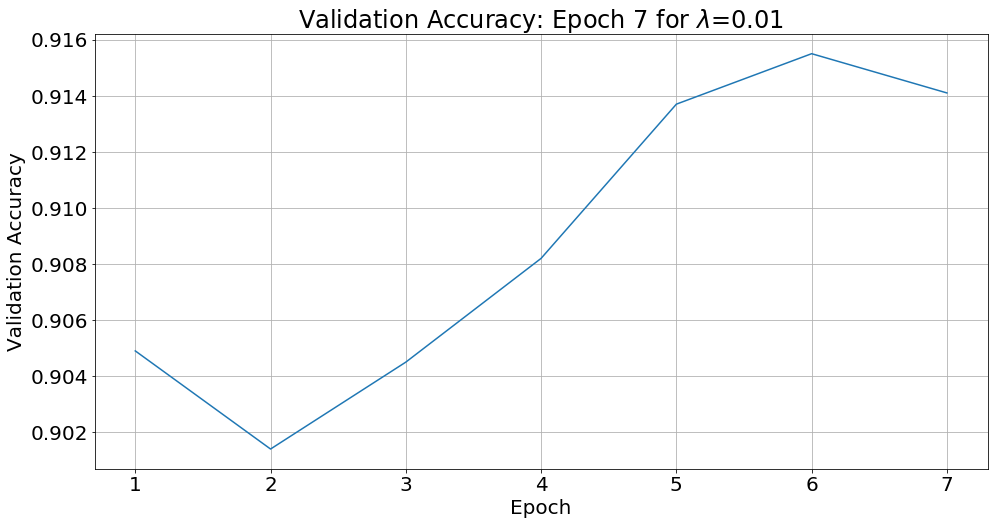

Dataset: Validation 
Accuracy: 9156/10000 (91.6%)



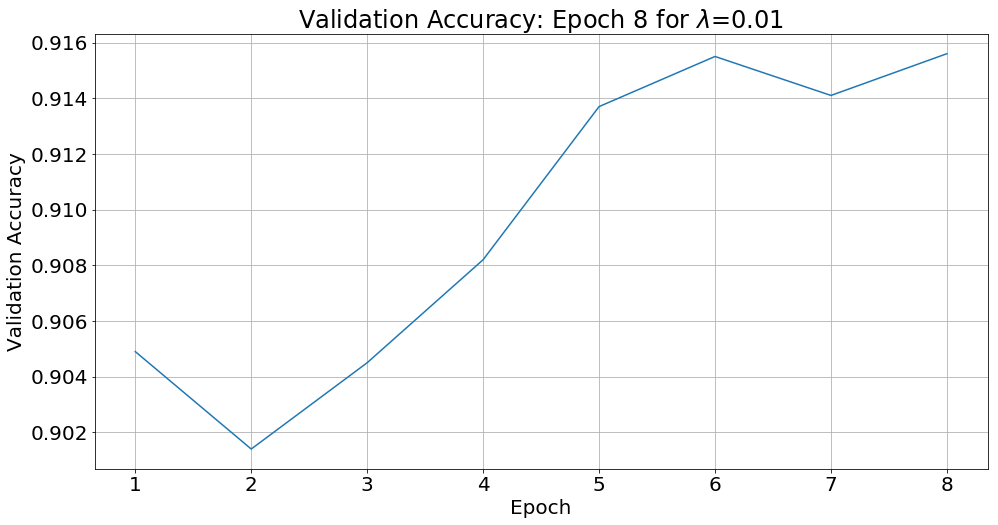

Dataset: Validation 
Accuracy: 9080/10000 (90.8%)



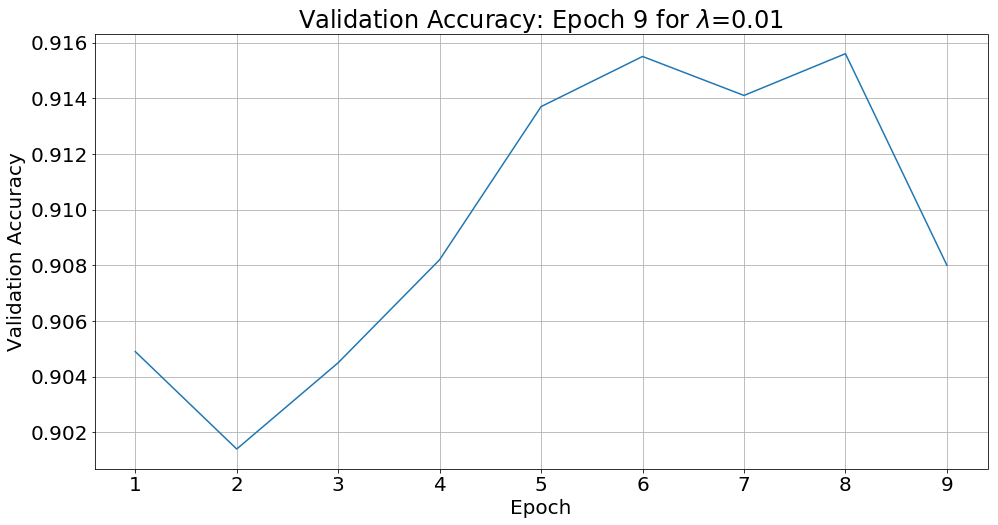

Dataset: Validation 
Accuracy: 9097/10000 (91.0%)



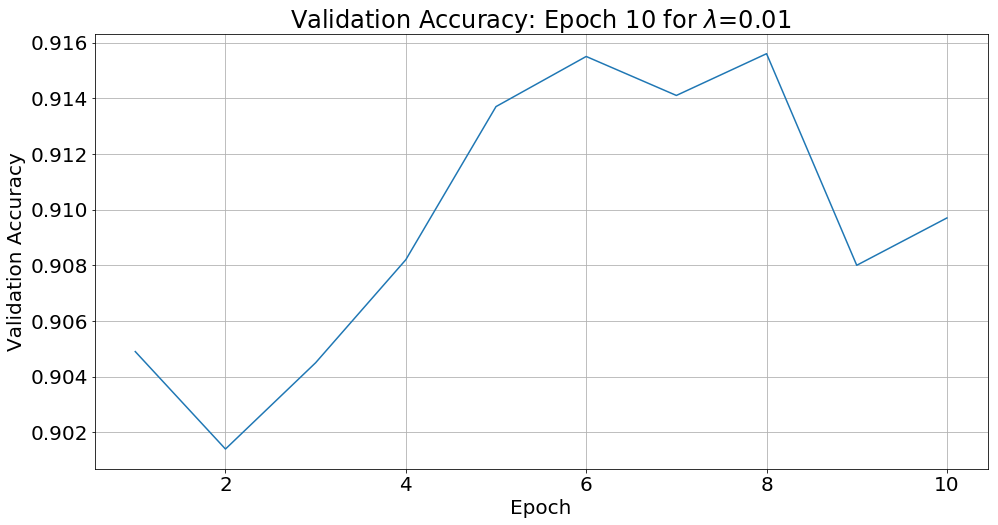

In [10]:
# 1.4. Train your model using SGD to minimize the cost function. 
# Use as many epochs as you need to achieve convergence.
if not mnc.is_fit():
    mnc.fit(viz_val_loss=True)

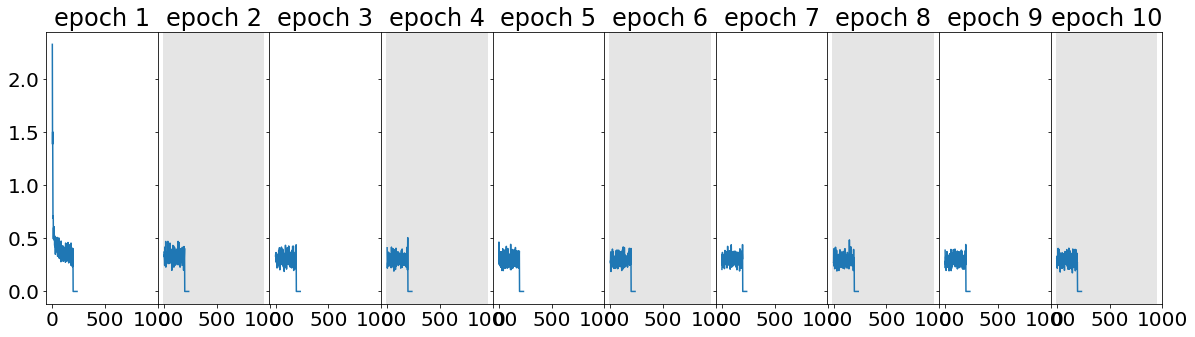

In [11]:
# 1.5. Plot the cross-entropy loss on the training set as a function of iteration.
mnc.viz_training_loss(epochs)

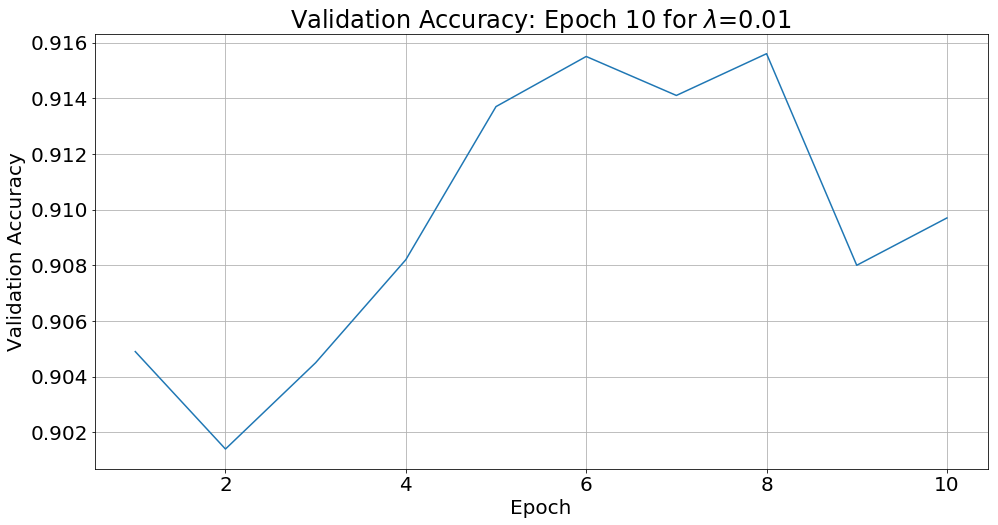

In [12]:
# 1.6a. Using classification accuracy, evaluate how well your model is performing on the validation set 
# at the end of each epoch. Plot this validation accuracy as the model trains.

# Plot done interactively as model trains
# Here is one version of it
mnc.viz_validation_loss(epochs-1)

Training simple logistic regression model with weight decay = 0.00031.
Dataset: Validation 
Accuracy: 8999/10000 (90.0%)

Dataset: Validation 
Accuracy: 9044/10000 (90.4%)

Dataset: Validation 
Accuracy: 9148/10000 (91.5%)

Dataset: Validation 
Accuracy: 9166/10000 (91.7%)

Dataset: Validation 
Accuracy: 9081/10000 (90.8%)

Dataset: Validation 
Accuracy: 9156/10000 (91.6%)

Dataset: Validation 
Accuracy: 9184/10000 (91.8%)

Dataset: Validation 
Accuracy: 9165/10000 (91.6%)

Dataset: Validation 
Accuracy: 9154/10000 (91.5%)

Dataset: Validation 
Accuracy: 9138/10000 (91.4%)



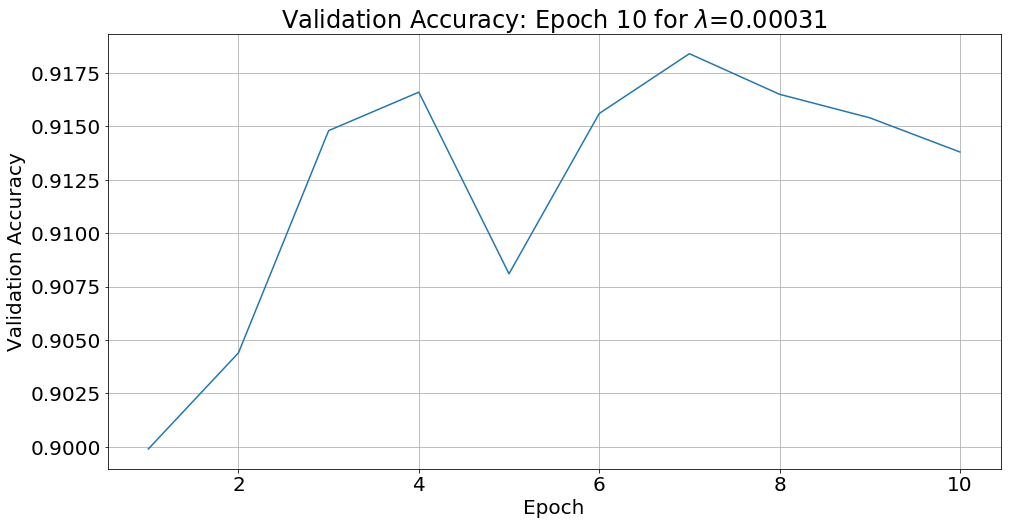

Training simple logistic regression model with weight decay = 0.001.
Dataset: Validation 
Accuracy: 9046/10000 (90.5%)

Dataset: Validation 
Accuracy: 9079/10000 (90.8%)

Dataset: Validation 
Accuracy: 9101/10000 (91.0%)

Dataset: Validation 
Accuracy: 9120/10000 (91.2%)

Dataset: Validation 
Accuracy: 9043/10000 (90.4%)

Dataset: Validation 
Accuracy: 9078/10000 (90.8%)

Dataset: Validation 
Accuracy: 9177/10000 (91.8%)

Dataset: Validation 
Accuracy: 9178/10000 (91.8%)

Dataset: Validation 
Accuracy: 9194/10000 (91.9%)

Dataset: Validation 
Accuracy: 9132/10000 (91.3%)



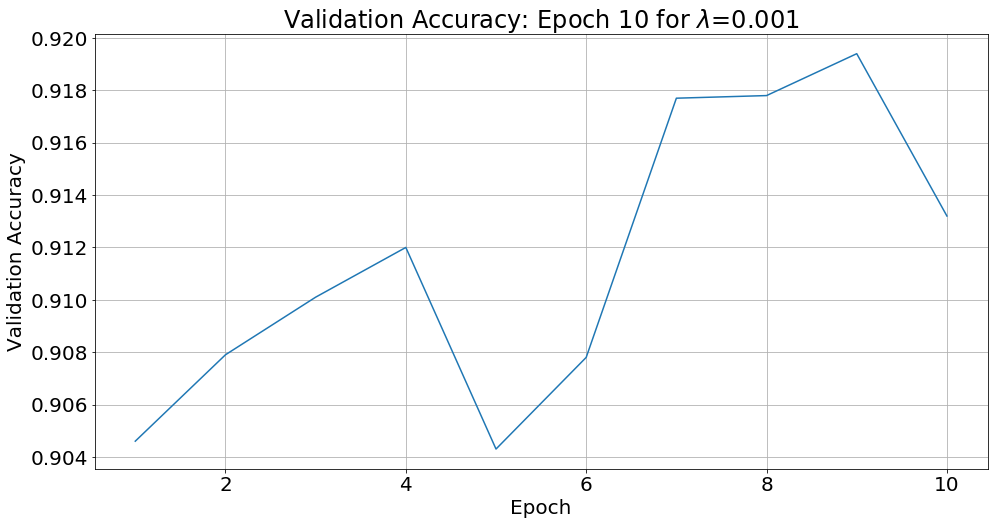

Training simple logistic regression model with weight decay = 0.0031.
Dataset: Validation 
Accuracy: 8961/10000 (89.6%)

Dataset: Validation 
Accuracy: 9052/10000 (90.5%)

Dataset: Validation 
Accuracy: 9084/10000 (90.8%)

Dataset: Validation 
Accuracy: 9012/10000 (90.1%)

Dataset: Validation 
Accuracy: 9152/10000 (91.5%)

Dataset: Validation 
Accuracy: 9105/10000 (91.0%)

Dataset: Validation 
Accuracy: 9133/10000 (91.3%)

Dataset: Validation 
Accuracy: 9140/10000 (91.4%)

Dataset: Validation 
Accuracy: 9086/10000 (90.9%)

Dataset: Validation 
Accuracy: 9114/10000 (91.1%)



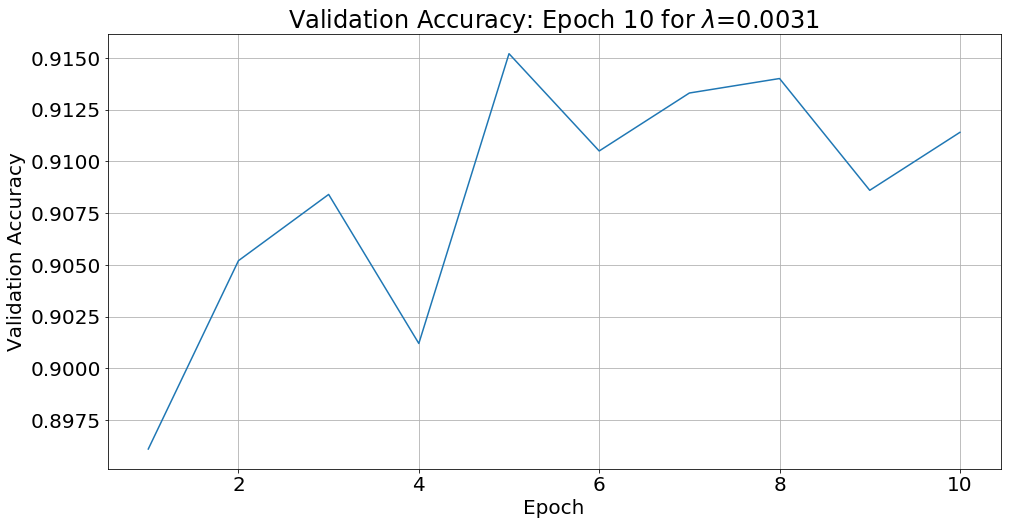

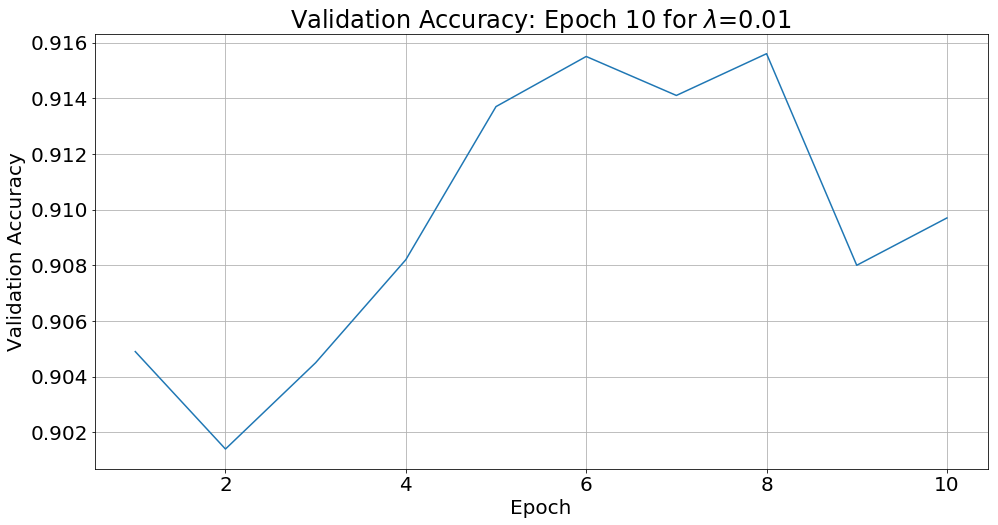

Training simple logistic regression model with weight decay = 0.031.
Dataset: Validation 
Accuracy: 8930/10000 (89.3%)

Dataset: Validation 
Accuracy: 8857/10000 (88.6%)

Dataset: Validation 
Accuracy: 8986/10000 (89.9%)

Dataset: Validation 
Accuracy: 8943/10000 (89.4%)

Dataset: Validation 
Accuracy: 8989/10000 (89.9%)

Dataset: Validation 
Accuracy: 8977/10000 (89.8%)

Dataset: Validation 
Accuracy: 8945/10000 (89.5%)

Dataset: Validation 
Accuracy: 8986/10000 (89.9%)

Dataset: Validation 
Accuracy: 8972/10000 (89.7%)

Dataset: Validation 
Accuracy: 9034/10000 (90.3%)



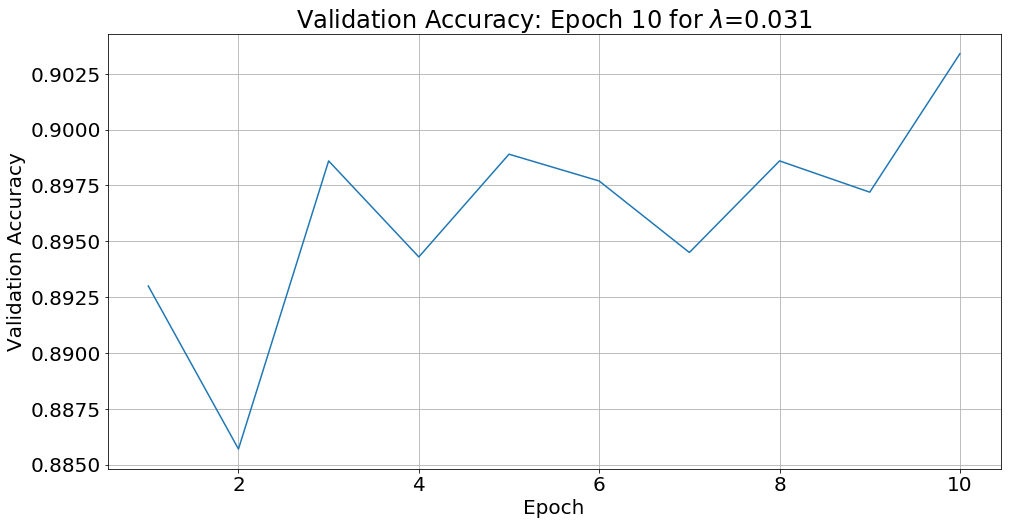

Training simple logistic regression model with weight decay = 0.1.
Dataset: Validation 
Accuracy: 8698/10000 (87.0%)

Dataset: Validation 
Accuracy: 8826/10000 (88.3%)

Dataset: Validation 
Accuracy: 8084/10000 (80.8%)

Dataset: Validation 
Accuracy: 8812/10000 (88.1%)

Dataset: Validation 
Accuracy: 8481/10000 (84.8%)

Dataset: Validation 
Accuracy: 8927/10000 (89.3%)

Dataset: Validation 
Accuracy: 8693/10000 (86.9%)

Dataset: Validation 
Accuracy: 8851/10000 (88.5%)

Dataset: Validation 
Accuracy: 8776/10000 (87.8%)

Dataset: Validation 
Accuracy: 8779/10000 (87.8%)



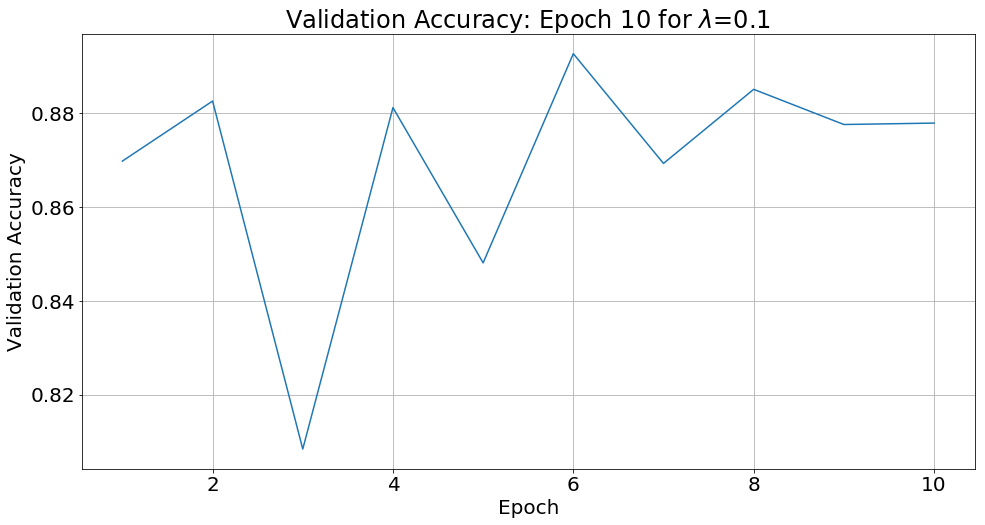

Training simple logistic regression model with weight decay = 0.31.
Dataset: Validation 
Accuracy: 8520/10000 (85.2%)

Dataset: Validation 
Accuracy: 8349/10000 (83.5%)

Dataset: Validation 
Accuracy: 8543/10000 (85.4%)

Dataset: Validation 
Accuracy: 7709/10000 (77.1%)

Dataset: Validation 
Accuracy: 8687/10000 (86.9%)

Dataset: Validation 
Accuracy: 8494/10000 (84.9%)

Dataset: Validation 
Accuracy: 7954/10000 (79.5%)

Dataset: Validation 
Accuracy: 8439/10000 (84.4%)

Dataset: Validation 
Accuracy: 8660/10000 (86.6%)

Dataset: Validation 
Accuracy: 8695/10000 (87.0%)



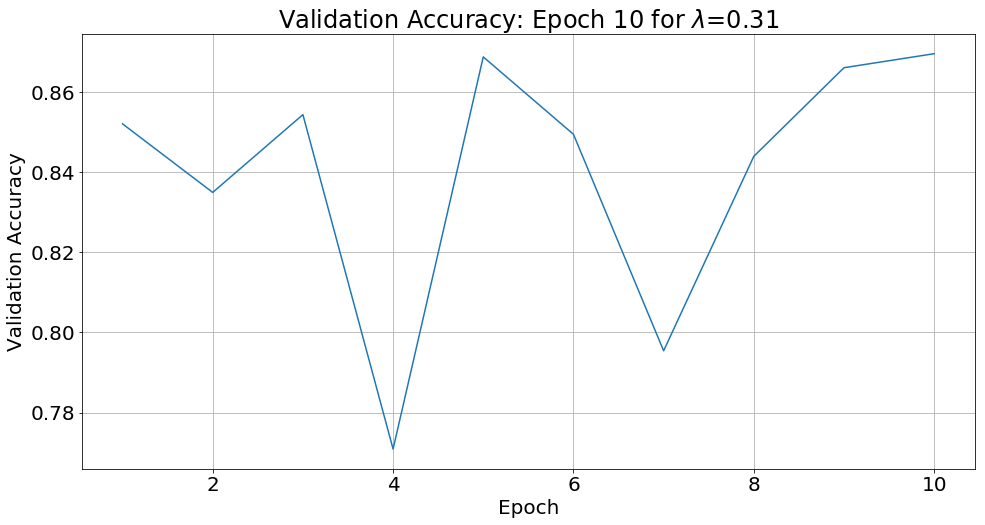

In [13]:
# 1.6b. Duplicate this plot for some other values of the regularization parameter λ. 
# When should you stop the training for each of the different values of λ? 
# Give an approximate answer supported by using the plots.

try:
    mncs_wd = vartbl['mncs_wd']
    weight_decays = list(mncs_wd.keys())
    num_wd = len(weight_decays)
    # Iterate over the weight decays and print the validation loss
    for mnc_wd in mncs_wd.values():
        mnc_wd.viz_validation_loss(epochs-1)
except:
    # Test seven values of lambda: the original value of 0.01, plus three log-spaced numbers on either side
    weight_decays = [0.00031, 0.001, 0.0031, 0.01, 0.031, 0.1, 0.31]
    num_wd = len(weight_decays)
    mncs_wd = dict()
    # Original weight decay to avoid refitting the same model
    wd_orig = mnc.get_params('weight_decay')
    # Iterate over the weight decays
    for weight_decay in weight_decays:
        # Don't duplicate weight decay we already ran
        if weight_decay == wd_orig:
            mncs_wd[weight_decay] = mnc
            mnc.viz_validation_loss(epochs-1)
            continue
        # Instantiate a model with this weight decay
        model = LogisticRegression()
        mnc_wd =  MNIST_Classifier(model=model,
                               learning_rate=learning_rate, 
                               weight_decay=weight_decay, 
                               batch_size=batch_size, 
                               validation_size=validation_size, 
                               epochs=epochs)
        # Train this model; turn off visualization of loss by epoch until the end of training
        print(f'Training simple logistic regression model with weight decay = {weight_decay}.')
        mnc_wd.fit(viz_val_loss=False)
        # Save this model to the dictionary mncs_wd
        mncs_wd[weight_decay] = mnc_wd
        # Save this to the vartbl
        vartbl['mncs_wd'] = mncs_wd
        save_vartbl(vartbl, fname)

I chose to sample a range of seven values of the regularization parameter $\lambda$.  The given value was 0.01.  I look three steps in either direction on log scale, with each step equal in size to the square root of 10 (approximately).  The list of all seven parameter values I tried was: [0.00031, 0.001, 0.0031, 0.01, 0.031, 0.1, 0.31].  I will list the best epoch to stop training each one:
\begin{align}
\begin{array}{rc}
\lambda & \text{epoch} \\
0.00031 & 10 \\
0.001 & 8 \\
0.0031 & 7 \\
0.01 & 9 \\
0.031 & 3 \\
0.1 & 4 \\
0.031 & 6 \\
\end{array}
\end{align}

These values are subjective and based on hindsight.  The idea is that once the model stops improving, it's probably a good idea to stop training.  There's a general trend toward the model needing fewer epochs to train when it has a higher regularization parameter $\lambda$, but the pattern is noisy.

In [14]:
# 1.7. Select what you consider the best regularization parameter and predict the labels of the test set. 
# Compare your predictions with the given labels. 
# What classification accuracy do you obtain on the training and test sets?

# Use weight_decay = 0.001 because it has the best scores (in general, not just at the peak or end)
wd_best = 0.001
mnc_best = mncs_wd[wd_best]


# Predict the labels on the training set
pred_train = np.array(mnc_best.predict('Train'))
labels_train = mnc_best.get_params('prediction_dataset_labels')
# Accuracy score on the test set
accuracy_train = mnc_best.score('Train')

# Predict the labels on the test set
pred_test = np.array(mnc_best.predict('Test'))
labels_test = mnc_best.get_params('prediction_dataset_labels')
# Accuracy score on the test set
accuracy_test = mnc_best.score('Test')

# Report the results
print(f'Accuracy on training and test data:')
print(f'Train: {accuracy_train*100:0.2f}%')
print(f'Test:  {accuracy_test*100:0.2f}%')

Dataset: Train 
Accuracy: 45973/50000 (91.9%)

Dataset: Test 
Accuracy: 9144/10000 (91.4%)

Accuracy on training and test data:
Train: 91.95%
Test:  91.44%


In [15]:
# 1.8. What classes are most likely to be misclassified? 
# Plot some misclassified training and test set images.

# Report errors on the test set
is_error = (pred_test != labels_test)
error_rate = np.zeros(10)
for d in range(0, 10):
    mask = (labels_test == d)
    count_d = np.sum(mask)
    error_d = np.sum(is_error[mask])
    error_rate[d] = error_d / count_d
# Get the three biggest error rates
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
top_errors = np.argpartition(error_rate, -3)[-3:][::-1]
print(f'Top three misclassified digits')
for d in top_errors:
    print(f'{d} : {error_rate[d]*100:0.2f}%')


Top three misclassified digits
3 : 17.52%
2 : 12.11%
8 : 11.50%


Misclassified Training Images:


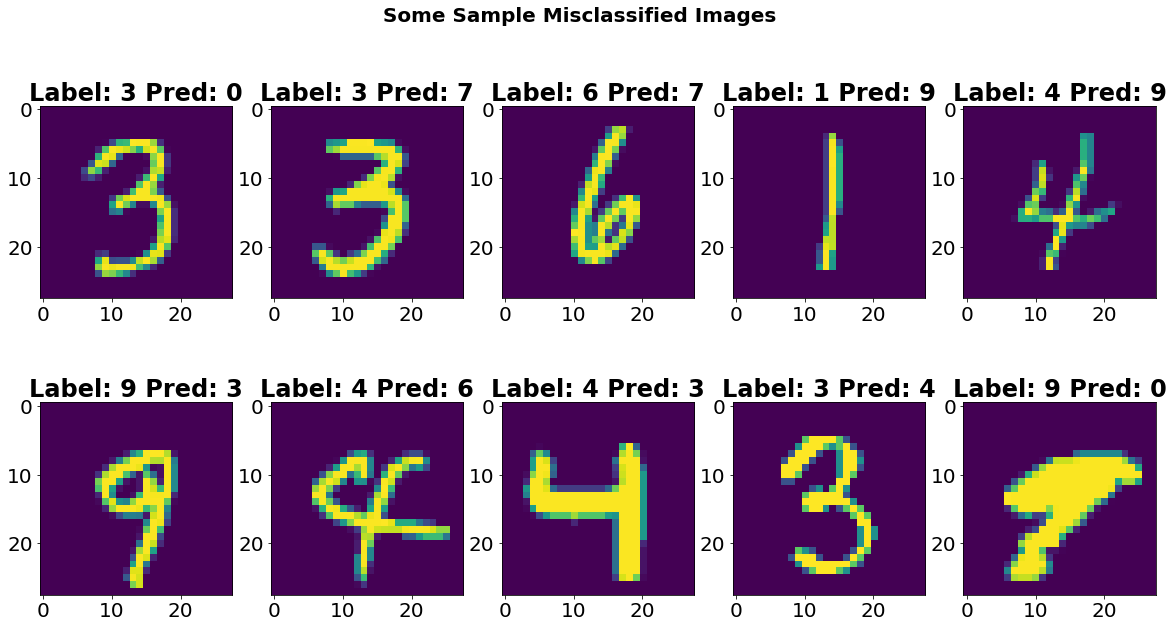

In [16]:
# Plot misclassified training images
print(f'Misclassified Training Images:')
mnc_best.predict('Train')
mnc_best.viz_misclassified_images()

Misclassified Test Images:


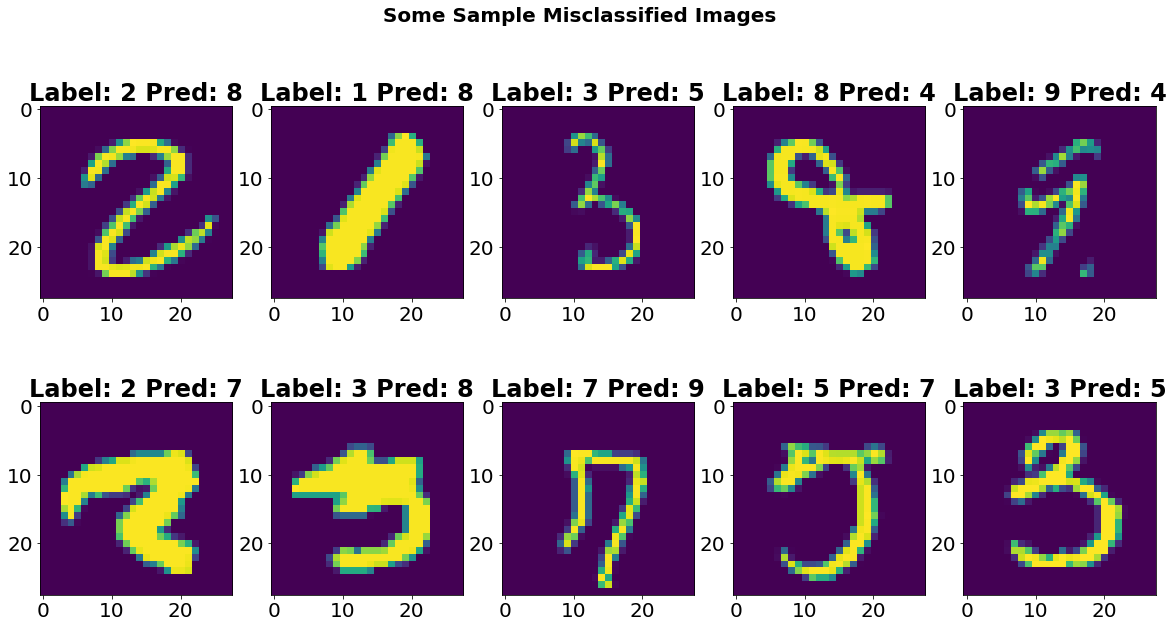

In [17]:
# Plot misclassified training images
print(f'Misclassified Test Images:')
mnc_best.predict('Test')
mnc_best.viz_misclassified_images()

## Question 2: MNIST MLP!  Find out what that means to me.  MNIST MLP!  Take care, TCB!

The multilayer perceptron can be understood as a logistic regression classifier in which the input is first transformed using a learnt non-linear transformation. The non-linear transformation is often chosen to be either the logistic function or the $\tanh$ function or the RELU function, and its purpose is to project the data into a space where it becomes linearly separable. The output of this so-called hidden layer is then passed to the logistic regression graph that we have constructed in the first problem. 

![](http://deeplearning.net/tutorial/_images/mlp.png)

We'll construct a model with **1 hidden layer**. That is, you will have an input layer, then a hidden layer with the nonlinearity, and finally an output layer with cross-entropy loss (or equivalently log-softmax activation with a negative log likelihood loss).

2.1. Using a similar architecture as in Question 1 and the same training, validation and test sets, build a PyTorch model for the multilayer perceptron. Use the $\tanh$ function as the non-linear activation function. 

2.2. The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the perceptron operate in a regime where information gets propagated. For the $\tanh$ function, you may find it advisable to initialize with the interval $\left[-\sqrt{\frac{6}{fan_{in}+fan_{out}}},\sqrt{\frac{6}{fan_{in}+fan_{out}}}\right]$, where $fan_{in}$ is the number of units in the $(i-1)$-th layer, and $fan_{out}$ is the number of units in the i-th layer.  This is known as **Xavier Initialization**.  Use Xavier Initialization to initialize your MLP.  Feel free to use PyTorch's in-built Xavier Initialization methods.

2.3. Using $\lambda = 0.01$ to compare with Question 1, experiment with the learning rate (try 0.1 and 0.01 for example), batch size (use 64, 128 and 256) and the number of units in your hidden layer (use between 25 and 200 units). For what combination of these parameters do you obtain the highest validation accuracy?  You may want to start with 20 epochs for running time and experiment a bit to make sure that your models reach convergence. 

2.4. For your best combination plot the cross-entropy loss on the training set as a function of iteration.

2.5. For your best combination use classification accuracy to evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

2.6. Select what you consider the best set of parameters and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?

2.7. How does your test accuracy compare to that of the logistic regression classifier in Question 1?  Compare best parameters for both models.

2.8. What classes are most likely to be misclassified? Plot some misclassified training and test set images.


**Gratuitous Titular Reference**:  Respect, originally performed by Otis Redding, became a huge hit and an anthem for the recently departed "Queen of Soul" Aretha Franklin.  Respect is often credited with popularizing the word usages "propers" (a synonym for respect) and "sock it to me".

In [18]:
# Load persisted table of variables
fname: str = 'mnist_q2.pickle'
vartbl: Dict = load_vartbl(fname)

In [19]:
# 2.1. Using a similar architecture as in Question 1 and the same training, validation and test sets, 
# build a PyTorch model for the multilayer perceptron. Use the tanh function as the non-linear activation function.

# Set key model parameters
num_hidden = 50
learning_rate = 0.1
weight_decay = 0.01
batch_size = 256
validation_size = 10000
epochs=20

# Handling - do we refit models in memory?
refit = False

# Train the logistic regression (i.e. softmax) model with the designated inputs
# Only run this block if the classifier not already in memory or the refit flag is set
try:    
    mnc = vartbl['mnc']
except:
    # Create a new instance of a logistic regression model
    model = TwoLayerNetwork(num_hidden)
    # Instantiate the MNIST Classifier- mnc for typability
    mnc = MNIST_Classifier(model=model,
                           learning_rate=learning_rate, 
                           weight_decay=weight_decay, 
                           batch_size=batch_size, 
                           validation_size=validation_size, 
                           epochs=epochs)

# Train the model
if not mnc.is_fit() or refit:
    # Fit the model
    mnc.fit(viz_val_loss=True)
    # Save the fitted model
    vartbl['mnc'] = mnc
    save_vartbl(vartbl, fname)

In [20]:
# 2.2. The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the 
# perceptron operate in a regime where information gets propagated. For the  tanhtanh  function, you may find it 
# advisable to initialize with the interval  [a,a]. This is known as Xavier Initialization. 
# Use Xavier Initialization to initialize your MLP. 
# Feel free to use PyTorch's in-built Xavier Initialization methods.

# Please see __init__ method for class TwoLayerNetwork 

In [21]:
# 2.3. Using  λ=0.01 to compare with Question 1, experiment with the learning rate (try 0.1 and 0.01 for example), 
# batch size (use 64, 128 and 256) and the number of units in your hidden layer (use between 25 and 200 units). 
# For what combination of these parameters do you obtain the highest validation accuracy? 
# You may want to start with 20 epochs for running time and experiment a bit to make sure that your 
# models reach convergence.


# Load the latest version of mncs if it's available
try:
    mncs = vartbl['mncs']
except:
    # Initialize an empty dictionary for mncs
    mncs = dict()

def test_parameters(mncs, learning_rates, batch_sizes, nums_hidden):
    """Iterate over all combinations of learning rate, batch size, and number of hidden units."""
    # Iteration counter
    i: int = 0
    # Compute total number of iterations
    iMax = len(learning_rates) * len(batch_sizes) * len(nums_hidden)
    skips = 0
    # Start the timer
    t0 = time.time()
    # Iterate over learning rates
    for learning_rate in learning_rates:
        # Iterate over batch sizes
        for batch_size in batch_sizes:
            # Iterate over number of hidden units
            for num_hidden in nums_hidden:
                # key for saving these parameter settings in the dictionary of models
                key = (learning_rate, batch_size, num_hidden)
                # Is this parameter setting already present in mncs? Then skip it.
                if key in mncs:
                    skips += 1
                    print(f'Already fit learning_rate={learning_rate}, batch_size={batch_size}, num_hidden={num_hidden}.')
                    continue
                # Create a two layer model with the given number of hidden units
                model = TwoLayerNetwork(num_hidden)
                # Create an MNIST classifier with the given learning rate and batch size
                mnc_curr = MNIST_Classifier(model=model,
                                       learning_rate=learning_rate, 
                                       weight_decay=weight_decay, 
                                       batch_size=batch_size, 
                                       validation_size=validation_size, 
                                       epochs=epochs)
                # Train this model; turn off visualization of loss by epoch until the end of training
                print(f'Training two layer network with learning_rate {learning_rate}, '
                      f'batch_size = {batch_size}, num_hidden={num_hidden}.')
                mnc_curr.fit(viz_val_loss=False)
                # Save this model to the dictionary mncs
                mncs[key] = mnc_curr
                # Save this to the vartbl
                vartbl['mncs'] = mncs
                save_vartbl(vartbl, fname)
                # Status update
                i += 1
                t1 = time.time()
                elapsed = (t1 - t0)
                projected = (iMax - skips - i) / i * elapsed
                print(f'Elapsed time {int(elapsed)}, projected remaining {int(projected)} (seconds).')

In [22]:
# 2.3
# Range of parameter settings to try
learning_rates = [0.1, 0.01]
batch_sizes = [64, 128, 256]
nums_hidden = [25, 50, 100, 200]

# Test these parameters
test_parameters(mncs, learning_rates, batch_sizes, nums_hidden)

# Try all of these parameters, because this is what they told us to do...
# WARNING - this takes a long time to run, even if you have a GPU :(
# Runtime on Microsoft Surface Pro 4 laptop with Intel i7-6650 @ 2208 MHz, 2 cores
# was about 90 minutes  

# Find the combination with the best validation accuracy
def best_val(mnc) -> float:
    """Return the best validation score of a model"""
    val_scores = mnc.get_params('validation_losses')
    best_epoch = np.argmax(val_scores)
    best_score = val_scores[best_epoch]
    return best_score

# Dictionary with best score achieved by each model
best_scores = {key : best_val(mnc) for key, mnc in mncs.items()}
# Find the best key and the corresponding best mnc
best_key = max(best_scores, key=lambda k : best_scores[k])
best_mnc = mncs[best_key]
best_score = best_val(best_mnc)
best_lr, best_batch_sz, best_hidden = best_key
# Report results
print(f'\nThe model with the best validation score had:')
print(f'Learning rate = {best_lr}')
print(f'Batch Size = {best_batch_sz}')
print(f'Hidden Units = {best_hidden}')
print(f'Validation Score = {best_score}')

Already fit learning_rate=0.1, batch_size=64, num_hidden=25.
Already fit learning_rate=0.1, batch_size=64, num_hidden=50.
Already fit learning_rate=0.1, batch_size=64, num_hidden=100.
Already fit learning_rate=0.1, batch_size=64, num_hidden=200.
Already fit learning_rate=0.1, batch_size=128, num_hidden=25.
Already fit learning_rate=0.1, batch_size=128, num_hidden=50.
Already fit learning_rate=0.1, batch_size=128, num_hidden=100.
Already fit learning_rate=0.1, batch_size=128, num_hidden=200.
Already fit learning_rate=0.1, batch_size=256, num_hidden=25.
Already fit learning_rate=0.1, batch_size=256, num_hidden=50.
Already fit learning_rate=0.1, batch_size=256, num_hidden=100.
Already fit learning_rate=0.1, batch_size=256, num_hidden=200.
Already fit learning_rate=0.01, batch_size=64, num_hidden=25.
Already fit learning_rate=0.01, batch_size=64, num_hidden=50.
Already fit learning_rate=0.01, batch_size=64, num_hidden=100.
Already fit learning_rate=0.01, batch_size=64, num_hidden=200.
Alre

As reported by the script above, the model with the best vaidation performance (95.71% accuracy) had:

Learning Rate = 0.1<br>
Batch Size = 128<br>
Hidden Units = 100<br>

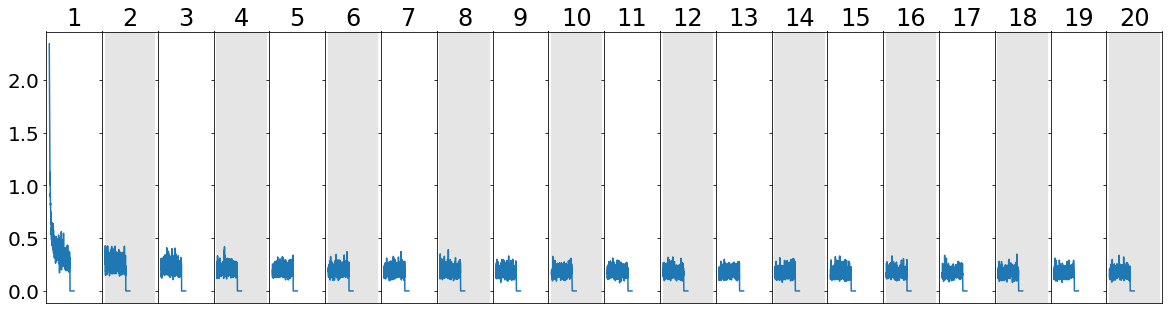

In [23]:
# 2.4. For your best combination plot the cross-entropy loss on the training set as a function of iteration.
losses = best_mnc.get_params("training_losses")
fig, axes = plt.subplots(nrows=1, ncols=epochs, figsize=(20,5), sharex=True, sharey=True)
for i in range(epochs):
    axes[i].plot(range(len(losses[i])), losses[i])
    axes[i].set_title(f'{i+1}')
    axes[i].set_xticks([])
    if i % 2 == 1:
        axes[i].axvspan(-10, 950, facecolor='gray', alpha=0.2)
plt.subplots_adjust(wspace=0)
plt.show()

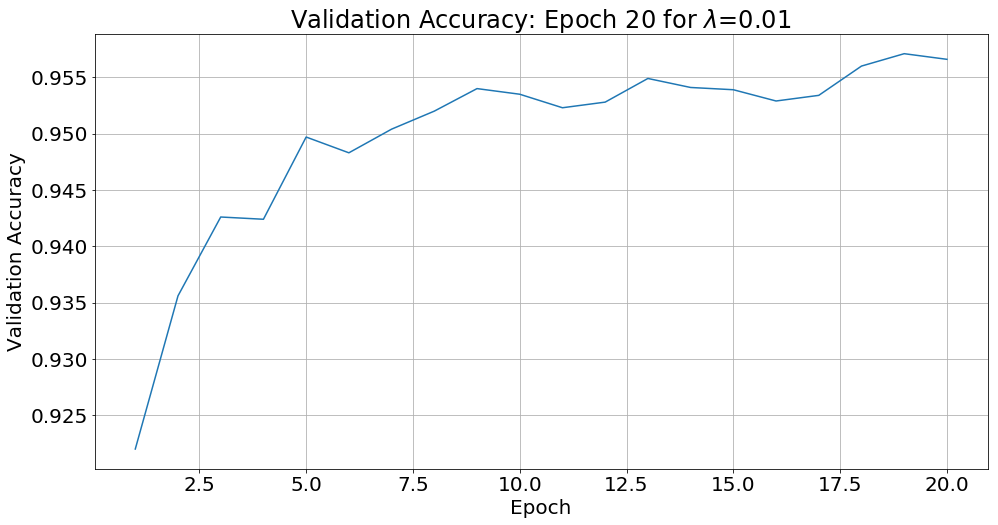

In [24]:
# 2.5. For your best combination use classification accuracy to evaluate how well your model is performing 
# on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

# The model training routine has a flag indicating whether or not to display the validation score
# live in training.  This was turned off when training all 24 models to avoid cluttering the screen
# with 24 models * 20 epochs = 480 intermediate charts
# Here is a single chart built after the fact showing the score vs. the epoch
best_mnc.viz_validation_loss(epochs-1)

In [25]:
# 2.6. Select what you consider the best set of parameters and predict the labels of the test set. 
# Compare your predictions with the given labels. 
# What classification accuracy do you obtain on the training and test sets?

# The model above scored the best on the validation set and it has reasonable settings.
# Let's use that one and see how it does on the test set.

# Predict the labels on the test set
pred_test = np.array(best_mnc.predict('Test'))
labels_test = best_mnc.get_params('prediction_dataset_labels')
# Accuracy score on the test set
accuracy_test = best_mnc.score('Test')

Dataset: Test 
Accuracy: 9570/10000 (95.7%)



**2.7** The accuracy of the two layer neural network was noticeably better: 95.7% vs. 91.8%.  That's an error rate of 4.3% vs. 8.2%, so almost a 50% reduction in the error rate.

The two layer network used L2 regularization parameter of 0.01.  This was bigger than the best weight decay of 0.001 found for the logistic regression.  This isn't surprising: the two layer network has more parameters, so it benefits from more regularization.

The learning rate for the LR model was 0.1.  This ended up being the same as the optimal learning rate for the two layer network.

The batch size for the LR model was 256.  The optimal batch size here turned out to be smaller at 128.  This suggests that the more complex two layer network benefited from taking a greater number of steps with diverse albeit noisy information about the gradient.  The less complex LR model (probably) preferred steps with less noisy estimates of the gradient.

There is no direct comparison between the number of hidden units because this parameter does not exist in the linear regression model.  It's worth noting that the root mean square of 784 (size of input layer) and 10 (size of output layer) is  88.5.  This isn't too far from the number of hidden units we chose, 100.  My intuition here is that information in each layer may effectively scale as the log of the size of the layer, and the network did well when the amount of "information" in the intermediate layer was roughly in between the input and output layers.

Top three misclassified digits
9 : 8.13%
5 : 6.39%
8 : 5.44%
Misclassified Training Images:


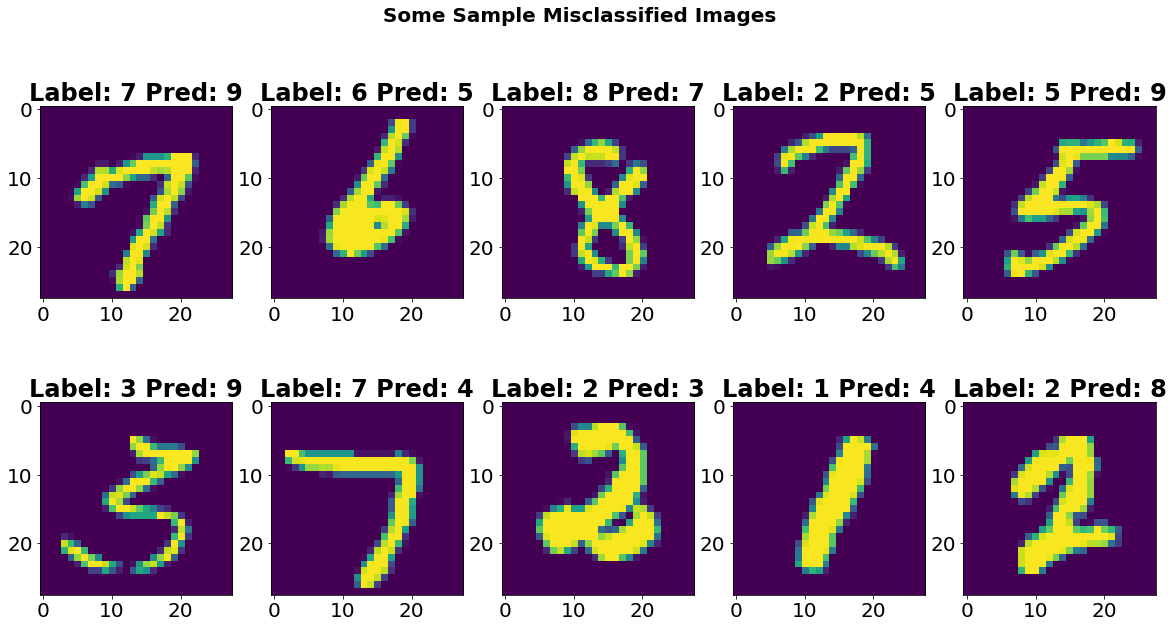

Misclassified Test Images:


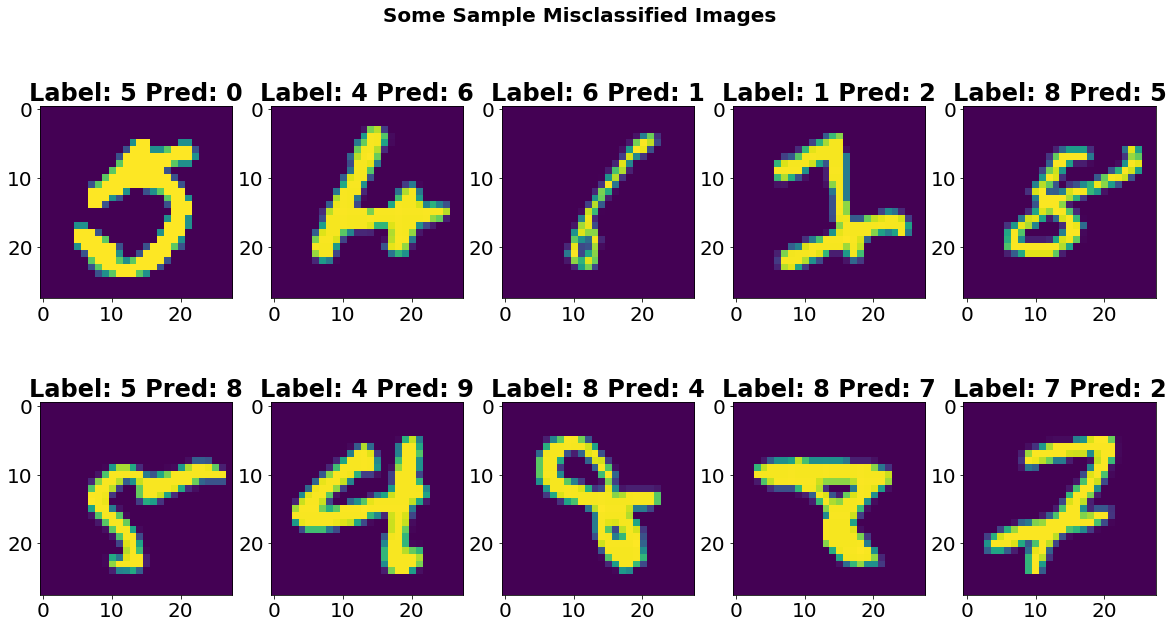

In [26]:
# 2.8. What classes are most likely to be misclassified? Plot some misclassified training and test set images.

# Report errors on the test set
is_error = (pred_test != labels_test)
error_rate = np.zeros(10)
for d in range(0, 10):
    mask = (labels_test == d)
    count_d = np.sum(mask)
    error_d = np.sum(is_error[mask])
    error_rate[d] = error_d / count_d
# Get the three biggest error rates
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
top_errors = np.argpartition(error_rate, -3)[-3:][::-1]
print(f'Top three misclassified digits')
for d in top_errors:
    print(f'{d} : {error_rate[d]*100:0.2f}%')

# Plot misclassified training images
print(f'Misclassified Training Images:')
best_mnc.predict('Train')
best_mnc.viz_misclassified_images()

# Plot misclassified training images
print(f'Misclassified Test Images:')
best_mnc.predict('Test')
best_mnc.viz_misclassified_images()

<div class="answer-separator">
------------------------
</div>